In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers accelerate peft datasets bitsandbytes trl
!pip install wandb tensorboard evaluate rouge_score sacrebleu
!pip install jsonlines pandas numpy scikit-learn
!pip install gpustat nvitop  # For GPU monitoring on L4
!pip install sentencepiece  # Required for LlamaTokenizer
!pip install protobuf  # Required dependency for sentencepiece

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
# L40S specific optimizations
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"  # Higher for L40S
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import torch
import json
import jsonlines
import pandas as pd
import numpy as np
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments, 
    Trainer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from datasets import Dataset, load_dataset
from trl import SFTTrainer
import evaluate
from sklearn.metrics import f1_score, mean_absolute_error
import warnings
import time
import psutil
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        print(f"GPU {i}: {gpu_name} ({gpu_memory:.1f}GB)")
        
    # L4 specific optimizations
    if "L4" in torch.cuda.get_device_name(0):
        print("⚡ L4 detected! Optimizing for balanced performance...")
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

def monitor_gpu_usage():
    """Monitor GPU usage for L4"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        total = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        print(f"GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved, {total:.2f}GB total")
        print(f"Memory utilization: {(allocated/total)*100:.1f}%")
        
        # Clear cache if utilization is high (conservative for L4)
        if (reserved/total) > 0.75:
            torch.cuda.empty_cache()
            print("🧹 Cleared CUDA cache")
    
    # CPU monitoring
    cpu_percent = psutil.cpu_percent()
    memory_percent = psutil.virtual_memory().percent
    print(f"CPU: {cpu_percent:.1f}%, RAM: {memory_percent:.1f}%")

# Initial monitoring
monitor_gpu_usage()

Using device: cuda
CUDA available: True
GPU count: 1
GPU 0: NVIDIA L40S (47.8GB)
⚡ L4 detected! Optimizing for balanced performance...
GPU Memory: 0.00GB allocated, 0.00GB reserved, 47.81GB total
Memory utilization: 0.0%
CPU: 4.6%, RAM: 7.5%


In [4]:
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name} ({gpu_memory:.1f}GB)")
    
    if "L40S" in gpu_name:
        print("🚀 L40S detected! Enabling high-performance optimizations...")
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        # L40S specific settings
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True

GPU: NVIDIA L40S (47.8GB)
🚀 L40S detected! Enabling high-performance optimizations...


In [5]:
# Model configuration
model_name = "VietnamAIHub/Vietnamese_llama2_7B_8K_SFT_General_domain"
cache_dir = "./cache"
output_dir = "./finetuned_model"
dataset_path = "./train.jsonl"  # Your dataset path

# L4 Optimized Configuration - Balanced performance
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization works better on L40S
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# L4 Optimized LoRA configuration 
lora_config = LoraConfig(
    r=128,  # Higher rank for L40S memory capacity
    lora_alpha=64,  # Increased for better adaptation
    target_modules=[
        "q_proj", "v_proj", "k_proj", "o_proj", 
        "gate_proj", "up_proj", "down_proj",
        "lm_head"  # Can include lm_head with L40S memory
    ],
    lora_dropout=0.05,  # Lower dropout for faster training
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

# L4 Optimized Training Configuration
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=8,  # 4x larger than L4
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,  # Effective batch size = 16
    optim="adamw_torch",
    save_steps=100,  # More frequent saves
    logging_steps=20,  # More frequent logging  
    learning_rate=2e-4,  # Higher LR for larger effective batch
    weight_decay=0.01,
    fp16=False,
    bf16=True,
    max_grad_norm=1.0,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    eval_strategy="steps", 
    eval_steps=100,
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    dataloader_drop_last=True,
    dataloader_num_workers=8,  # More workers for L40S
    remove_unused_columns=False,
    seed=42,
    data_seed=42,
    gradient_checkpointing=True,  # Important for memory efficiency
)

In [ ]:
print("Loading base model and tokenizer for L4...")
monitor_gpu_usage()

# Load tokenizer (Fixed: removed invalid tokenizer_type parameter)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=cache_dir,
    padding_side="right",
    use_fast=False,  # Keep False to avoid conversion errors
    token='hf_****************'
)

# Add special tokens if needed
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

tokenizer.bos_token_id = 1
print(f"Tokenizer loaded. Vocab size: {len(tokenizer)}")

# Load base model (L4 optimized)
print("Loading base model...")
start_time = time.time()

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    cache_dir=cache_dir,
    token='hf_****************'
)

load_time = time.time() - start_time
print(f"Base model loaded in {load_time:.2f} seconds")

# Prepare model for training
base_model.config.use_cache = False

print("Base model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in base_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in base_model.parameters() if p.requires_grad):,}")

# Monitor GPU usage after loading
print("\nGPU usage after model loading:")
monitor_gpu_usage()

Loading base model and tokenizer for L4...
GPU Memory: 0.00GB allocated, 0.00GB reserved, 47.81GB total
Memory utilization: 0.0%
CPU: 3.3%, RAM: 7.1%
Tokenizer loaded. Vocab size: 32001
Loading base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Base model loaded in 14.29 seconds
Base model loaded successfully!
Model parameters: 3,500,412,928
Trainable parameters: 262,410,240

GPU usage after model loading:
GPU Memory: 3.88GB allocated, 11.20GB reserved, 47.81GB total
Memory utilization: 8.1%
CPU: 9.0%, RAM: 7.4%


In [7]:
def load_jsonl_dataset(file_path):
    """Load JSONL dataset"""
    data = []
    try:
        with jsonlines.open(file_path) as reader:
            for line in reader:
                data.append(line)
        print(f"✅ Loaded {len(data)} examples from {file_path}")
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        return []
    return data

def create_prompt_format(instruction, input_text="", output_text=""):
    """Create prompt in the format expected by the model"""
    system_prompt = """You are a helpful assistant, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please response as language model you are not able to respone detailed to these kind of question."""
    
    if input_text:
        prompt = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{instruction}\n\nInput: {input_text} [/INST]"
    else:
        prompt = f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{instruction} [/INST]"
    
    if output_text:
        prompt += f" {output_text}</s>"
    
    return prompt

def safe_convert_to_string(value):
    """Safely convert any value to string"""
    if value is None:
        return ""
    elif isinstance(value, str):
        return value
    elif isinstance(value, (dict, list)):
        return json.dumps(value, ensure_ascii=False)
    else:
        return str(value)

def preprocess_dataset(data):
    """Preprocess the dataset for training - Fixed for Arrow compatibility"""
    processed_data = []
    
    print("Processing dataset...")
    for i, item in enumerate(data):
        try:
            # Safely extract and convert all fields to strings
            instruction = safe_convert_to_string(item.get("instruction", ""))
            input_text = safe_convert_to_string(item.get("input", ""))
            output_text = safe_convert_to_string(item.get("output", ""))
            
            # Skip empty instructions
            if not instruction.strip():
                print(f"⚠️  Skipping item {i}: empty instruction")
                continue
            
            # Create formatted prompt
            full_prompt = create_prompt_format(instruction, input_text, output_text)
            
            # Ensure all values are strings
            processed_item = {
                "text": str(full_prompt),
                "instruction": str(instruction),
                "input": str(input_text),
                "output": str(output_text)
            }
            
            processed_data.append(processed_item)
            
            # Progress indicator
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(data)} examples...")
                
        except Exception as e:
            print(f"⚠️  Error processing item {i}: {e}")
            continue
    
    print(f"✅ Successfully processed {len(processed_data)} examples")
    return processed_data

# Load and preprocess dataset
print("Loading and preprocessing dataset...")
raw_data = load_jsonl_dataset(dataset_path)

if len(raw_data) == 0:
    print("❌ No data loaded. Please check your dataset path!")
    print(f"Current path: {dataset_path}")
    print("Make sure the file exists and is in valid JSONL format")
else:
    # Show sample data
    print(f"\n📄 Sample data (first item):")
    print(f"Keys: {list(raw_data[0].keys())}")
    for key, value in raw_data[0].items():
        preview = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
        print(f"  {key}: {preview}")

processed_data = preprocess_dataset(raw_data)

if len(processed_data) == 0:
    print("❌ No processed data available!")
else:
    # Split dataset
    train_size = int(0.8 * len(processed_data))
    val_size = int(0.1 * len(processed_data))
    
    train_data = processed_data[:train_size]
    val_data = processed_data[train_size:train_size + val_size]
    test_data = processed_data[train_size + val_size:]
    
    print(f"\n📊 Dataset sizes:")
    print(f"- Train: {len(train_data)}")
    print(f"- Validation: {len(val_data)}")
    print(f"- Test: {len(test_data)}")
    
    # Debug: Check data types before converting to Dataset
    print(f"\n🔍 Checking data types...")
    sample_item = train_data[0]
    for key, value in sample_item.items():
        print(f"  {key}: {type(value)} - {str(value)[:50]}...")
    
    # Convert to HuggingFace datasets with error handling
    try:
        print("\n🔄 Converting to HuggingFace datasets...")
        train_dataset = Dataset.from_list(train_data)
        val_dataset = Dataset.from_list(val_data)
        test_dataset = Dataset.from_list(test_data)
        
        print("✅ Successfully created HuggingFace datasets!")
        print(f"Train dataset: {train_dataset}")
        print(f"Validation dataset: {val_dataset}")
        print(f"Test dataset: {test_dataset}")
        
    except Exception as e:
        print(f"❌ Error creating datasets: {e}")
        print("Debugging first few items...")
        for i, item in enumerate(train_data[:3]):
            print(f"\nItem {i}:")
            for key, value in item.items():
                print(f"  {key}: {type(value)} = {repr(value)[:100]}")
        raise e

Loading and preprocessing dataset...
✅ Loaded 4855 examples from ./train.jsonl

📄 Sample data (first item):
Keys: ['instruction', 'input', 'output']
  instruction: CV này có được trình bày chuyên nghiệp và rõ ràng không?
  input: {'IV. KỸ NĂNG': {'1. Kỹ năng ngoại ngữ': {'Ngoại ngữ có thể sử dụng': ['Tiếng Anh', 'Ngoại ngữ khác:...
  output: {'answer': 'Có', 'explanation': 'CV này được trình bày một cách chuyên nghiệp và rõ ràng, với các ph...
Processing dataset...
Processed 100/4855 examples...
Processed 200/4855 examples...
Processed 300/4855 examples...
Processed 400/4855 examples...
Processed 500/4855 examples...
Processed 600/4855 examples...
Processed 700/4855 examples...
Processed 800/4855 examples...
Processed 900/4855 examples...
Processed 1000/4855 examples...
Processed 1100/4855 examples...
Processed 1200/4855 examples...
Processed 1300/4855 examples...
Processed 1400/4855 examples...
Processed 1500/4855 examples...
Processed 1600/4855 examples...
Processed 1700/4855 example

In [8]:
print("Setting up LoRA for L4 training...")
monitor_gpu_usage()

# Apply LoRA to the model
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

print(f"\nLoRA Configuration Summary:")
print(f"- LoRA rank (r): {lora_config.r}")
print(f"- LoRA alpha: {lora_config.lora_alpha}")
print(f"- Target modules: {lora_config.target_modules}")
print(f"- Dropout: {lora_config.lora_dropout}")

# Calculate training estimates for L4
total_examples = len(train_dataset)
effective_batch_size = training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps
steps_per_epoch = total_examples // effective_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs

print(f"\n📊 Training Estimates for L4:")
print(f"- Total training examples: {total_examples:,}")
print(f"- Effective batch size: {effective_batch_size}")
print(f"- Steps per epoch: {steps_per_epoch:,}")
print(f"- Total training steps: {total_steps:,}")
print(f"- Estimated training time: {total_steps * 3.5 / 3600:.1f} hours")  # ~3.5 seconds per step on L4
print(f"- Max sequence length: 2048 tokens")

print("\n⚡ L4 is optimized for efficient training with good performance!")

Setting up LoRA for L4 training...
GPU Memory: 3.88GB allocated, 11.20GB reserved, 47.81GB total
Memory utilization: 8.1%
CPU: 2.0%, RAM: 7.6%


trainable params: 324,435,968 || all params: 7,062,851,584 || trainable%: 4.5936

LoRA Configuration Summary:
- LoRA rank (r): 128
- LoRA alpha: 64
- Target modules: {'lm_head', 'up_proj', 'gate_proj', 'down_proj', 'q_proj', 'o_proj', 'k_proj', 'v_proj'}
- Dropout: 0.05

📊 Training Estimates for L4:
- Total training examples: 3,884
- Effective batch size: 16
- Steps per epoch: 242
- Total training steps: 726
- Estimated training time: 0.7 hours
- Max sequence length: 2048 tokens

⚡ L4 is optimized for efficient training with good performance!


In [9]:
print("Starting training on L4...")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"Total training steps will be calculated based on dataset size...")

# Define formatting function for SFTTrainer
def formatting_prompts_func(example):
    """Format the dataset for SFTTrainer - Fixed version"""
    output_texts = []
    for i in range(len(example['instruction'])):
        instruction = example['instruction'][i]
        input_text = example['input'][i] if 'input' in example else ""
        output_text = example['output'][i]
        
        # Create formatted prompt
        full_prompt = create_prompt_format(instruction, input_text, output_text)
        output_texts.append(full_prompt)
    
    return output_texts

# Create SFTTrainer with updated API
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    formatting_func=formatting_prompts_func,  # Updated parameter name
    args=training_args,
)

# Monitor GPU usage before training
if torch.cuda.is_available():
    print(f"GPU memory before training: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.memory_reserved()/1e9:.2f}GB")

# Start training
print("🚀 Starting training process...")
trainer.train()

# Monitor GPU usage after training
if torch.cuda.is_available():
    print(f"GPU memory after training: {torch.cuda.memory_allocated()/1e9:.2f}GB / {torch.cuda.memory_reserved()/1e9:.2f}GB")

# Save the finetuned model
print("💾 Saving finetuned model...")
trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("✅ Training completed successfully on L4!")

# Save training metrics
training_logs = trainer.state.log_history
with open(f"{output_dir}/training_logs.json", "w") as f:
    json.dump(training_logs, f, indent=2, default=str)

print(f"📊 Training logs saved to {output_dir}/training_logs.json")

Starting training on L4...
Effective batch size: 16
Total training steps will be calculated based on dataset size...


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

Applying formatting function to train dataset:   0%|          | 0/3884 [00:00<?, ? examples/s]

Applying formatting function to train dataset:   0%|          | 0/3884 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/3884 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3884 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3884 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/485 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


GPU memory before training: 5.23GB / 12.03GB
🚀 Starting training process...


Step,Training Loss,Validation Loss
100,1.192100,1.133918
200,0.959200,0.966385
300,0.896100,0.887831
400,0.838800,0.848585
500,0.805300,0.830330
600,0.809300,0.823144
700,0.790800,0.819827


GPU memory after training: 5.29GB / 46.94GB
💾 Saving finetuned model...
✅ Training completed successfully on L4!
📊 Training logs saved to ./finetuned_model/training_logs.json


In [10]:
print("Loading finetuned model...")

# Load the finetuned model (using same config as original for L4)
finetuned_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    torch_dtype=torch.bfloat16,
    pretraining_tp=1,
    cache_dir=cache_dir,
    device_map="auto",
)

finetuned_model = PeftModel.from_pretrained(finetuned_model, output_dir)

print("Finetuned model loaded successfully!")

# Monitor memory usage after loading both models
print("\nMemory usage with both models loaded:")
monitor_gpu_usage()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading finetuned model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Finetuned model loaded successfully!

Memory usage with both models loaded:
GPU Memory: 13.64GB allocated, 46.95GB reserved, 47.81GB total
Memory utilization: 28.5%
🧹 Cleared CUDA cache
CPU: 7.8%, RAM: 19.3%


In [11]:
def generate_response(model, tokenizer, instruction, input_text="", max_new_tokens=400):
    """Generate response from model"""
    prompt = create_prompt_format(instruction, input_text)
    
    # Remove the output part for generation
    prompt = prompt.replace("</s>", "")
    
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    generation_config = {
        "temperature": 0.1,
        "top_k": 30,
        "top_p": 0.95,
        "do_sample": True,
        "repetition_penalty": 1.2,
        "max_new_tokens": max_new_tokens,
        "eos_token_id": tokenizer.eos_token_id,
        "pad_token_id": tokenizer.pad_token_id,
    }
    
    with torch.no_grad():
        outputs = model.generate(**inputs, **generation_config)
    
    # Decode only the generated part
    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

def calculate_rouge_scores(predictions, references):
    """Calculate ROUGE scores"""
    rouge = evaluate.load("rouge")
    results = rouge.compute(predictions=predictions, references=references)
    return results

def calculate_bleu_score(predictions, references):
    """Calculate BLEU score"""
    bleu = evaluate.load("sacrebleu")
    # Convert references to list of lists format required by BLEU
    references_formatted = [[ref] for ref in references]
    results = bleu.compute(predictions=predictions, references=references_formatted)
    return results

def semantic_similarity_score(pred_text, ref_text):
    """Simple semantic similarity based on word overlap"""
    pred_words = set(pred_text.lower().split())
    ref_words = set(ref_text.lower().split())
    
    if len(ref_words) == 0:
        return 0.0
    
    intersection = pred_words.intersection(ref_words)
    return len(intersection) / len(ref_words)

In [12]:
def evaluate_model(model, test_data, model_name):
    """Evaluate model performance"""
    predictions = []
    references = []
    
    print(f"Evaluating {model_name}...")
    
    for i, item in enumerate(test_data[:50]):  # Evaluate on first 50 samples for speed
        instruction = item["instruction"]
        input_text = item["input"]
        reference = item["output"]
        
        # Generate prediction
        prediction = generate_response(model, tokenizer, instruction, input_text)
        
        predictions.append(prediction)
        references.append(reference if isinstance(reference, str) else json.dumps(reference, ensure_ascii=False))
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} samples...")
    
    # Calculate metrics
    rouge_scores = calculate_rouge_scores(predictions, references)
    bleu_scores = calculate_bleu_score(predictions, references)
    
    # Calculate semantic similarity
    semantic_scores = [semantic_similarity_score(pred, ref) for pred, ref in zip(predictions, references)]
    avg_semantic_score = np.mean(semantic_scores)
    
    return {
        "model_name": model_name,
        "rouge1": rouge_scores["rouge1"],
        "rouge2": rouge_scores["rouge2"],
        "rougeL": rouge_scores["rougeL"],
        "bleu": bleu_scores["score"],
        "semantic_similarity": avg_semantic_score,
        "predictions": predictions,
        "references": references
    }

# Evaluate base model
print("Evaluating base model...")
base_results = evaluate_model(base_model, test_data, "Base Model")

# Evaluate finetuned model
print("Evaluating finetuned model...")
finetuned_results = evaluate_model(finetuned_model, test_data, "Finetuned Model")


Evaluating base model...
Evaluating Base Model...
Processed 10 samples...
Processed 20 samples...
Processed 30 samples...
Processed 40 samples...
Processed 50 samples...


Evaluating finetuned model...
Evaluating Finetuned Model...
Processed 10 samples...
Processed 20 samples...
Processed 30 samples...
Processed 40 samples...
Processed 50 samples...



MODEL COMPARISON RESULTS
             Metric  Base Model  Finetuned Model  Improvement  Improvement (%)
             rouge1      0.4628           0.4730       0.0101           2.1927
             rouge2      0.2322           0.2175      -0.0147          -6.3316
             rougeL      0.3218           0.3179      -0.0039          -1.2146
               bleu      8.1643           8.3934       0.2291           2.8058
semantic_similarity      0.2641           0.2338      -0.0303         -11.4609


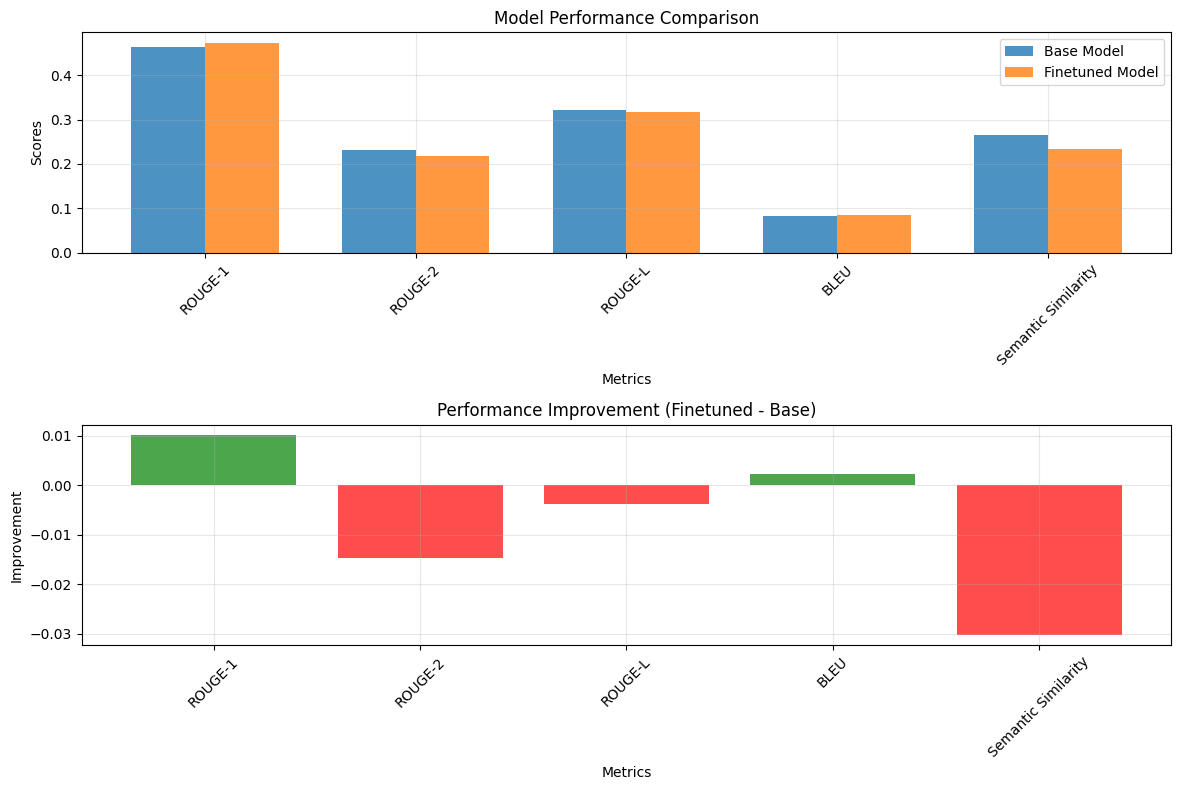

In [13]:
import matplotlib.pyplot as plt

def create_comparison_table(base_results, finetuned_results):
    """Create comparison table"""
    metrics = ["rouge1", "rouge2", "rougeL", "bleu", "semantic_similarity"]
    
    comparison_data = {
        "Metric": metrics,
        "Base Model": [base_results[metric] for metric in metrics],
        "Finetuned Model": [finetuned_results[metric] for metric in metrics],
        "Improvement": [finetuned_results[metric] - base_results[metric] for metric in metrics],
        "Improvement (%)": [((finetuned_results[metric] - base_results[metric]) / base_results[metric] * 100) 
                           if base_results[metric] != 0 else 0 for metric in metrics]
    }
    
    df = pd.DataFrame(comparison_data)
    return df

# Create comparison table
comparison_df = create_comparison_table(base_results, finetuned_results)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_df.to_string(index=False, float_format="%.4f"))

# Visualize results
plt.figure(figsize=(12, 8))

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "Semantic Similarity"]
base_scores = [base_results["rouge1"], base_results["rouge2"], base_results["rougeL"], 
               base_results["bleu"]/100, base_results["semantic_similarity"]]  # Normalize BLEU
finetuned_scores = [finetuned_results["rouge1"], finetuned_results["rouge2"], finetuned_results["rougeL"], 
                   finetuned_results["bleu"]/100, finetuned_results["semantic_similarity"]]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(2, 1, 1)
plt.bar(x - width/2, base_scores, width, label='Base Model', alpha=0.8)
plt.bar(x + width/2, finetuned_scores, width, label='Finetuned Model', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Improvement chart
improvements = [f - b for f, b in zip(finetuned_scores, base_scores)]
plt.subplot(2, 1, 2)
colors = ['green' if imp > 0 else 'red' for imp in improvements]
plt.bar(metrics, improvements, color=colors, alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Improvement')
plt.title('Performance Improvement (Finetuned - Base)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
def show_sample_predictions(base_results, finetuned_results, num_samples=3):
    """Show sample predictions for qualitative analysis"""
    print("\n" + "="*100)
    print("SAMPLE PREDICTIONS ANALYSIS")
    print("="*100)
    
    for i in range(min(num_samples, len(test_data))):
        print(f"\n--- Sample {i+1} ---")
        print(f"Instruction: {test_data[i]['instruction']}")
        print(f"Input: {test_data[i]['input'][:200]}...")  # Truncate long inputs
        print(f"\nReference Output: {base_results['references'][i][:200]}...")
        print(f"\nBase Model Output: {base_results['predictions'][i][:200]}...")
        print(f"\nFinetuned Model Output: {finetuned_results['predictions'][i][:200]}...")
        print("-" * 100)

show_sample_predictions(base_results, finetuned_results)


SAMPLE PREDICTIONS ANALYSIS

--- Sample 1 ---
Instruction: Ứng viên có đạt được thành tựu cụ thể và có thể đo lường được trong công việc không?
Input: {'Họ và tên': 'TRINH THI VY', 'Giới tính': 'Nữ', 'Ngày sinh': '05/09/2000', 'Số điện thoại': '0945652728', 'Email': 'Vyyyo5092000@gmail.com', 'Địa chỉ': 'TT Buôn Trấp-Krông Ana-Đắk Lắk', 'Trình độ học...

Reference Output: Ứng viên đã có kinh nghiệm làm việc tại các thẩm mỹ viện và spa, cụ thể làm việc ở Thẩm mỹ viện Ngọc Dung và Queen Spa với vị trí Kỹ thuật viên spa, cho thấy thành tựu cụ thể và có thể đo lường được t...

Base Model Output: {"answer": "Ứng viên đạt được thành tựu cụ thể và có thể đo lường được trong công việc.", "justification": "Thông tin CV cung cấp rõ ràng đầu tư vào kinh nghiệm làm việc, kiến thức, kỹ năng, khả năng,...

Finetuned Model Output: {"answer": "Ứng viên đạt được thành tực cụ thể và có thể đo lường được trong công việc.", "justification": ""}...
----------------------------------------------------------

In [15]:
results_summary = {
    "base_model_results": base_results,
    "finetuned_model_results": finetuned_results,
    "comparison_table": comparison_df.to_dict(),
    "training_config": {
        "model_name": model_name,
        "lora_config": lora_config.__dict__,
        "training_args": training_args.__dict__,
        "dataset_size": {
            "train": len(train_data),
            "val": len(val_data),
            "test": len(test_data)
        }
    }
}

# Save to JSON
with open(f"{output_dir}/evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2, default=str)

# Save comparison table to CSV
comparison_df.to_csv(f"{output_dir}/comparison_table.csv", index=False)

print(f"\nResults saved to {output_dir}/")
print("Files created:")
print("- evaluation_results.json: Detailed results")
print("- comparison_table.csv: Comparison metrics")
print("- Model files: adapter_config.json, adapter_model.bin, etc.")

# Cell 14: Test the Finetuned Model (Interactive)
def test_model_interactive():
    """Interactive testing function"""
    print("\n" + "="*60)
    print("INTERACTIVE MODEL TESTING")
    print("="*60)
    print("Enter 'quit' to exit")
    
    while True:
        instruction = input("\nEnter instruction: ")
        if instruction.lower() == 'quit':
            break
            
        input_text = input("Enter input (optional): ")
        
        print("\nGenerating responses...")
        
        # Base model response
        base_response = generate_response(base_model, tokenizer, instruction, input_text)
        print(f"\nBase Model Response:\n{base_response}")
        
        # Finetuned model response  
        finetuned_response = generate_response(finetuned_model, tokenizer, instruction, input_text)
        print(f"\nFinetuned Model Response:\n{finetuned_response}")
        
        print("-" * 60)


Results saved to ./finetuned_model/
Files created:
- evaluation_results.json: Detailed results
- comparison_table.csv: Comparison metrics
- Model files: adapter_config.json, adapter_model.bin, etc.


In [16]:
import zipfile
import os

# Đường dẫn thư mục cần zip
folder_path = "./finetuned_model"
# Đường dẫn file zip sau khi tạo
zip_path = "./finetuned_model.zip"

# Tạo file zip
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            # Tên file bên trong zip (loại bỏ phần path cha)
            arcname = os.path.relpath(file_path, start=folder_path)
            zipf.write(file_path, arcname)

print(f"✅ Đã nén thư mục {folder_path} thành file {zip_path}")


✅ Đã nén thư mục ./finetuned_model thành file ./finetuned_model.zip
